# 03 Homofilia temática entre usuarios
## Objetivo: vectorizar a los usuarios en base a los tópicos sobre los cuales *tweetearon* y evaluar la similitud entre usuarios utilizando dichos vectores. 
Lo que haremos aquí es observar la similaridad que existe entre usuarios de acuerdo a los tópicos sobre los cuales hablan. Los tópicos son los que detectamos en el notebook ** 02 Matriz de coocurrencia de *hashtags* **

Computamos valores de similitud entre usuarios dentro del grafo de usuarios:
- pares de usuarios que se siguen en la red **vs** pares de usuarios tomados al azar
- pares de usuarios que se siguen en la red clasificandolos como:
    * usuarios que siguen al mismo candidato
    * usuarios que siguen a distintos candidatos

In [1]:
%pylab inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer

paleta = mpl.cm.viridis

Populating the interactive namespace from numpy and matplotlib


# Parámetros de generación de la red de hashtags
- USAR_RETWEETS: usar hashtags provenientes de todos los tweets o únicamente aquellos que no fueron retweets
- UMBRAL: cantidad mínima de veces que coocurren dos hashtags en tweets para estar presentes en la búsqueda de topicos
- FILTRAR_ENTROPIA: aplicar filtro de entropía de aquellos hashtags que fueron usados por los cuatro grupos de seguidores de políticos mas uniformemente

In [2]:
USAR_RETWEETS = False
UMBRAL = 3
FILTRAR_ENTROPIA = True

In [3]:
user_hashtags = pd.read_csv('csv_files/user_hashtags.csv')
user_hashtags.head(3)

,user_id,timestamp,hashtag
0,186068,2015-11-05 17:48:32,PasanteDeClarín
1,186068,2015-11-03 21:41:31,QueVuelvaElFav
2,186068,2015-10-25 15:03:35,NingunaSanta


In [4]:
hashtags = pd.read_csv('csv_files/hashtags.csv')

In [5]:
def extract_oslom():
    """Leemos las comunidades que extrajimos en el notebook 02 Matriz coocurrencia hashtags """
    if (USAR_RETWEETS):
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'.csv')
    else:
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'_sin_retweets.csv')

def get_user_hashtag_topic():
    """Devuelve un DataFrame de la forma: usuario,topico, cantidad de usos del topico
    Eliminamos aquellos topicos que fueron utilizados menos de tres veces"""
    df = extract_oslom()
    grouped = df.groupby("cluster").count().reset_index()[["cluster", "id"]]
    grouped.columns = ["cluster", "topic_count"]
    grouped = grouped[grouped.topic_count >= 3]
    df = df.merge(grouped)
    #df = df.merge(hashtags, left_on="hashtag_id", right_on="id")
    df = df.merge(hashtags)
    df = df.merge(user_hashtags)
    return df

In [6]:
usuario_topico_df = get_user_hashtag_topic()
usuario_topico_df.head(3)

,id,cluster,topic_count,hashtag,user_id,timestamp
0,10,673,38,Gol,186068,2015-10-15 01:42:09
1,10,673,38,Gol,77779,2015-09-26 14:06:21
2,10,673,38,Gol,77779,2015-09-26 14:03:52


In [7]:
mat_df = usuario_topico_df.groupby(["user_id", "cluster"]).count().reset_index()
mat_df.head()

,user_id,cluster,id,topic_count,hashtag,timestamp
0,1,476,1,1,1,1
1,1,677,1,1,1,1
2,1,705,1,1,1,1
3,1,936,4,4,4,4
4,1,995,1,1,1,1


In [8]:
mat_df.cluster.max()

1403

In [9]:
mat_df.user_id.max()

308167

In [10]:
user_indexes = [u for u in mat_df.user_id.values]
topic_indexes = [c for c in mat_df.cluster.values]
values = mat_df.id.values
matr = coo_matrix((values, (user_indexes, topic_indexes)),shape=(308169, mat_df.cluster.max() + 1))
matr = matr.tocsr()
matr

<308169x1404 sparse matrix of type '<class 'numpy.int64'>'
	with 2200797 stored elements in Compressed Sparse Row format>

In [11]:
# Tenemos la matriz usuario-topico, aplicamos TF-IDF con norma L2
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(matr)
tfidf

<308169x1404 sparse matrix of type '<class 'numpy.float64'>'
	with 2200797 stored elements in Compressed Sparse Row format>

In [12]:
if (USAR_RETWEETS):
    sp.save_npz('npz_files/tfidf_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA), tfidf, compressed=True)
else:
    sp.save_npz('npz_files/tfidf_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'_sin_retweets', tfidf, compressed=True)

In [13]:
followers = pd.read_csv('csv_files/followers.csv')
followers.head()

,follower_id,followed_id
0,240934,137027
1,175625,137027
2,227929,137027
3,87299,137027
4,8534,137027


# 1. Pares de usuarios que se siguen en la red **vs** pares de usuarios tomados al azar

In [14]:
# Creamos listado de la forma seguidor,seguido,similaridad
similarity = []
for index, row in followers.iterrows():
    if (len(tfidf[row["follower_id"]].data) != 0 and len(tfidf[row["followed_id"]].data != 0)):
        sim_row = [row["follower_id"], row["followed_id"]]
        ans = tfidf[row["follower_id"]].dot(tfidf[row["followed_id"]].T).data
        if (len(ans)==1):
            # Evitar similitudes igual a cero
            sim_row.append(ans[0])
            similarity.append(sim_row)
similarity[:10]

[[66877, 93195, 0.94391126019886729],
 [250869, 93195, 0.20351668414924662],
 [41951, 93195, 0.22055088526234268],
 [102050, 93195, 0.93950087012220918],
 [264803, 93195, 0.026011021441729613],
 [75944, 93195, 0.91739366471480432],
 [217651, 93195, 0.72182368038353262],
 [249554, 93195, 0.27424948319954795],
 [282065, 93195, 0.25086005569815129],
 [137745, 93195, 0.94493262174298698]]

In [15]:
followers_sim_df = pd.DataFrame(similarity, columns=["follower", "followed", "similarity"])
followers_sim_df.head()

,follower,followed,similarity
0,66877,93195,0.943911
1,250869,93195,0.203517
2,41951,93195,0.220551
3,102050,93195,0.939501
4,264803,93195,0.026011


In [16]:
gr = followers_sim_df.groupby("follower").agg(['median', 'count']).reset_index()
gr.columns = ["follower", "followed_id_median", "followed_count", "similaridad", "cantidad"]
gr = gr[["follower", "similaridad", "cantidad"]]
gr.head()

,follower,similaridad,cantidad
0,1,0.008439,1
1,2,0.424067,13
2,4,0.510721,1
3,6,0.602534,1
4,7,0.078517,6


In [17]:
tfidf2 = tfidf[tfidf.getnnz(1)>0]
tfidf2

<203953x1404 sparse matrix of type '<class 'numpy.float64'>'
	with 2200797 stored elements in Compressed Sparse Row format>

In [18]:
upper = tfidf2.shape[0]
upper

203953

In [19]:
# Por cada usuario tenemos un estadistico sobre la medida de similaridad con sus vecinos
# por ello, tomamos a un usuario y comparamos con la misma cantidad de personas al azar
random_sample_sim = []
for index, row in gr.iterrows():
    for c in range(int(row["cantidad"])):
        rand_row = [row["follower"]]
        user1 = np.random.randint(0, upper)
        user2 = np.random.randint(0, upper)
        ans = tfidf2[user1].dot(tfidf2[user2].T).data
        if (len(ans) == 1):
            rand_row.append(ans[0])
            random_sample_sim.append(rand_row)
len(random_sample_sim)

1802927

In [20]:
df_random = pd.DataFrame(random_sample_sim, columns = ["follower", "similaridad"])
df_random.head()

,follower,similaridad
0,2.0,0.272716
1,2.0,0.032959
2,2.0,0.004825
3,2.0,0.017468
4,2.0,0.093022


In [21]:
gr_random = df_random.groupby("follower").median().reset_index()
gr_random.head(2)

,follower,similaridad
0,2.0,0.046770
1,6.0,0.063717


In [22]:
sim = gr["similaridad"].values
ran = gr_random["similaridad"].values

/home/tomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


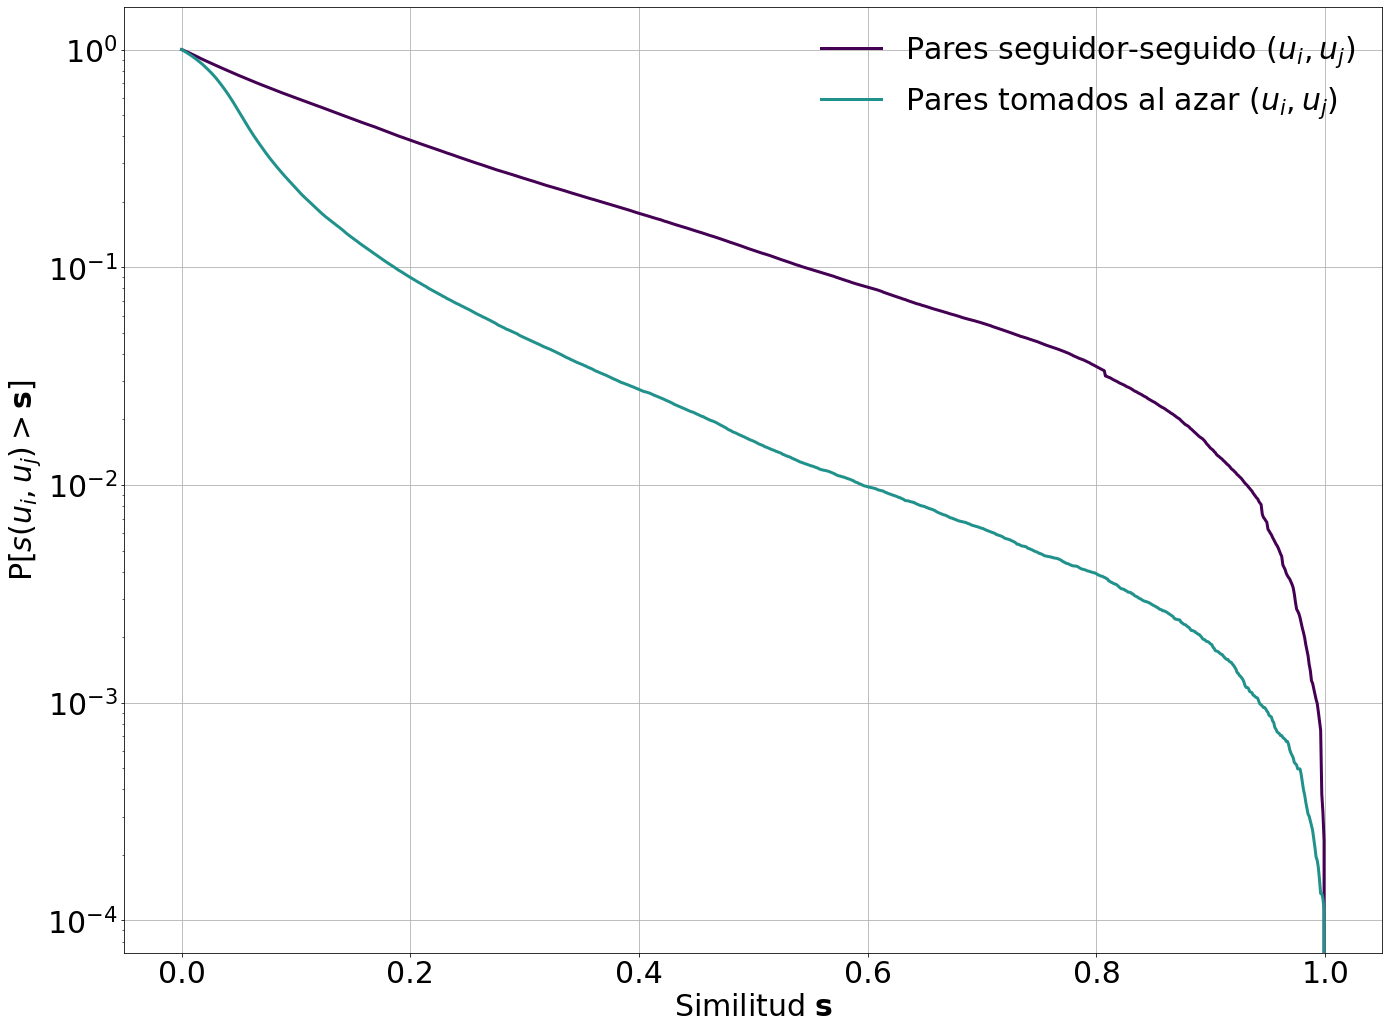

In [23]:
# ECDF
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 30})

ax = plt.axes()
ax.set_prop_cycle('color',[paleta(i) for i in np.linspace(0, 1, 3)])

ax1=subplot()
ecdf = sm.distributions.ECDF(sim)
ecdf2 = sm.distributions.ECDF(ran)

x = np.linspace(0, 1, 1000)
y = 1-ecdf(x)
y2 = 1-ecdf2(x)
ax1.plot(x, y, label="Pares seguidor-seguido $(u_{i},u_{j})$", linewidth=3)
ax1.plot(x, y2, label="Pares tomados al azar $(u_{i},u_{j})$", linewidth=3)
plt.legend(frameon=False)
plt.yscale('log')
plt.xlabel("Similitud $\\bf{s}$")
plt.ylabel("P[$s(u_{i},u_{j}) > \\bf{s}$]")
plt.grid()
figure = plt.gcf()
figure.set_size_inches(20, 15)
plt.tight_layout()
plt.show()

# 2. Pares de usuarios que se siguen en la red: mismo candidato vs candidatos distintos

In [24]:
if (not 'followers' in locals()):
    followers = pd.read_csv('csv_files/followers.csv')
followers.head()

,follower_id,followed_id
0,240934,137027
1,175625,137027
2,227929,137027
3,87299,137027
4,8534,137027


In [25]:
macri_id = 137027
scioli_id = 188326
massa_id = 12218
stolbizer_id = 224325

In [26]:
todos_macri = followers[followers["followed_id"] == macri_id].follower_id.values
todos_scioli = followers[followers["followed_id"] == scioli_id].follower_id.values
todos_massa = followers[followers["followed_id"] == massa_id].follower_id.values
todos_stolbizer = followers[followers["followed_id"] == stolbizer_id].follower_id.values

In [27]:
user_clusters = {}
def fill_user_clusters(followers, cluster):
    """Para cada grupo de seguidores, asignar una clase"""
    for i in followers:
        if not i in user_clusters:
            user_clusters[i] = set()
        user_clusters[i].add(cluster)
fill_user_clusters(todos_macri, 0)
fill_user_clusters(todos_scioli, 1)
fill_user_clusters(todos_massa, 2)
fill_user_clusters(todos_stolbizer, 3)

In [28]:
if (not 'tfidf' in locals()):
    if (USAR_RETWEETS):
        tfidf = sp.load_npz('npz_files/tfidf_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+".npz")
    else:
        tfidf = sp.load_npz('npz_files/tfidf_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'_sin_retweets.npz')
tfidf

<308169x1404 sparse matrix of type '<class 'numpy.float64'>'
	with 2200797 stored elements in Compressed Sparse Row format>

In [29]:
same_com = []
diff_com = []
for index, row in followers.iterrows():
    fol_r = int(row["follower_id"])
    fol_d = int(row["followed_id"])
    #Dejamos solo los casos en que cada uno esta en su comunidad distinta a la del otro (union 2, int 0),
    #o bien estan los dos en la misma y unica (union 1, int 1)
    if ((fol_r not in user_clusters or fol_d not in user_clusters) or
           (len(user_clusters[fol_r].union(user_clusters[fol_d])) +
                   len(user_clusters[fol_r].intersection(user_clusters[fol_d])) != 2 )):
        continue
    ans = tfidf[row["follower_id"]].dot(tfidf[row["followed_id"]].T).data
    if (len(ans)!=1):
        # Evitar ceros
        continue
    if (not user_clusters[fol_r].isdisjoint(user_clusters[fol_d])):
        # Si los conjuntos de comunidades no son disjuntos, siguen al mismo candidato
        same_com.append(ans[0])
    else:
        diff_com.append(ans[0])

In [30]:
len(same_com)

317045

In [31]:
len(diff_com)

81949

/home/tomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


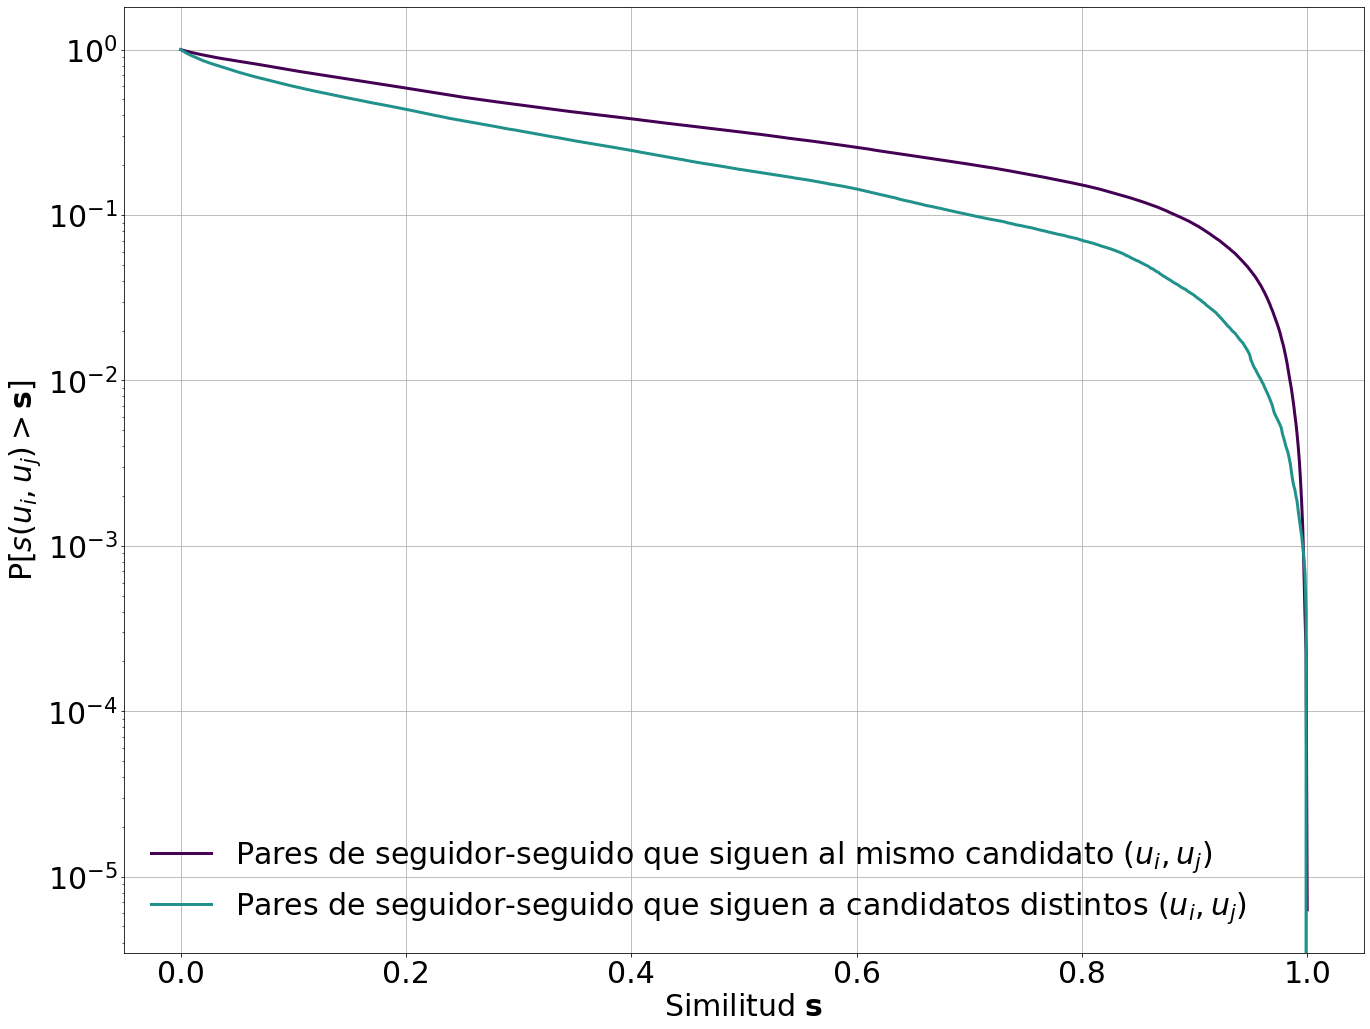

In [32]:
# ECDF
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 30})

ax = plt.axes()
ax.set_prop_cycle('color',[paleta(i) for i in np.linspace(0, 1, 3)])

ax1=subplot()
ecdf = sm.distributions.ECDF(same_com)
ecdf2 = sm.distributions.ECDF(diff_com)

x = np.linspace(0, 1, 1000)
y = 1-ecdf(x)
y2 = 1-ecdf2(x)
ax1.plot(x, y, label="Pares de seguidor-seguido que siguen al mismo candidato $(u_{i},u_{j})$", linewidth=3)
ax1.plot(x, y2, label="Pares de seguidor-seguido que siguen a candidatos distintos $(u_{i},u_{j})$", linewidth=3)
plt.legend(frameon=False)
plt.yscale('log')
plt.xlabel("Similitud $\\bf{s}$")
plt.ylabel("P[$s(u_{i},u_{j}) > \\bf{s}$]")
plt.grid()
figure = plt.gcf() # get current figure
figure.set_size_inches(20, 15)
plt.tight_layout()
plt.show()